<a href="https://colab.research.google.com/github/BrendanL72/ACM-Research-Coding-Challenge-F21/blob/main/Sentiment_Analysis_RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Info
This code was shamelessly ripped/adapted from the "Text classification with an RNN" tutorial offered by the TensorFlow website.

https://www.tensorflow.org/text/tutorials/text_classification_rnn

Additions made by Brendan Lim

This was created for ACM Research

This program was created in Google Colab and therefore be run in that environment.

#Setup

The IMDB reviews are part of the imported TensorFlow Datasets library. As such it does not need to be downloaded from the internet and can be loaded by name.

In [1]:
import numpy as np

import tensorflow_datasets as tfds
import tensorflow as tf

In [2]:
#used for graphing the learning progress of the learning model
import matplotlib.pyplot as plt


def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

Loading the directory of imdb_reviews into a Dataset object and splitting it into training and testing datasets.

In [3]:
dataset, info = tfds.load('imdb_reviews', 
                          with_info =True,
                          as_supervised = True) #VERY IMPORTANT, dataset contains unsupervised data

train_dataset, test_dataset = dataset['train'], dataset['test']

train_dataset.element_spec

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteMRC2J9/imdb_reviews-train.tfrecord


  0%|          | 0/25000 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteMRC2J9/imdb_reviews-test.tfrecord


  0%|          | 0/25000 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteMRC2J9/imdb_reviews-unsupervised.tfrecord


  0%|          | 0/50000 [00:00<?, ? examples/s]

Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


(TensorSpec(shape=(), dtype=tf.string, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

Get a random review to make sure that the data has been loaded in properly

In [4]:
for example, label in train_dataset.take(1):
  print('Text: ', example.numpy())
  print('Rating: ', label.numpy())

Text:  b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it."
Rating:  0


Prefetching some random data from the training and testing datasets to make sure everything works

In [5]:
#Constants to determine the amount of data we are prefetching
BUFFER_SIZE = 10000
BATCH_SIZE = 64

train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [33]:
num_loops = 1
num_reviews_show = 3
for example, label in train_dataset.take(num_loops):
  #print('TEXTS: ', example.numpy()[:num_reviews_show])
  for text in example.numpy()[:num_reviews_show]:
    print(text[:500], '\n')
  print()
  print('RATINGS: ', label.numpy()[:num_reviews_show])

b"The only thing serious about this movie is the humor. Well worth the rental price. I'll bet you watch it twice. It's obvious that Sutherland enjoyed his role." 

b"Love is overwhelming... In all it's manifestations... Gorgeous, absolutely gorgeous... Tudor Chirila, Maria Popistasu and Ioana Barbu, one truly dramatic story about love in all it's shapes, a story about the undecipherable ways of young hearts, about life and lost innocence all directed by the skillful eye of Tudor Giurgiu. With a magnificent soundtrack featuring Faultline & Chris Martin and Vama Veche it surprises in every way leaving behind the sour taste of misunderstanding love... Truly rem" 

b"This Movie is complete crap! Avoid this waste of celluloid at all costs, it is rambling and incoherent. I pride myself on plumbing the depths of 70's sleaze cinema from everything from Salo to Salon Kitty. I like being shocked, but I need a coherent story. However if watching horses mate gets you off this film is for you. The 

#Creating the text encoder

Notes:
*   Too few allowed vocabulary causes more of the tokens to be unknown ([UNK]) but also run slower 

*   keras.layers.experimental.preprocessing.TextVectorization() processes the text into an array of processed, lowercase tokens that is then turned into vectors. It is a layer. There is a variation that does not preprocess.

*   The adapt() method can be used on a layer to look at the dataset and creates a vocabulary based on the frequency of the words

In [7]:
MAX_VOCAB = 1000 #sets the max number of words the computer can know

encoder = tf.keras.layers.experimental.preprocessing.TextVectorization(
    max_tokens=MAX_VOCAB)

encoder.adapt(train_dataset.map(lambda text, label: text))

In [8]:
vocab = np.array(encoder.get_vocabulary())
#see the most used words, dtype not included
vocab[:30]

array(['', '[UNK]', 'the', 'and', 'a', 'of', 'to', 'is', 'in', 'it', 'i',
       'this', 'that', 'br', 'was', 'as', 'for', 'with', 'movie', 'but',
       'film', 'on', 'not', 'you', 'are', 'his', 'have', 'he', 'be',
       'one'], dtype='<U14')

Testing to see if the numberized token array exists.

In [9]:
encoded_example = encoder(example)[:3].numpy()
encoded_example

array([[156, 308,  11, ...,   0,   0,   0],
       [  2, 839,   6, ...,   0,   0,   0],
       [ 11,  18,   7, ...,   0,   0,   0]])

Compares the original text with what the computer reads using its limited vocabulary

In [10]:
for n in range(3):
  print("Original: ", example[n].numpy())
  print("Round-trip: ", " ".join(vocab[encoded_example[n]]))
  print()

Original:  b'Before seeing this movie, I would\'ve said that I loved everything Kathy Bates has done. Now it\'s everything-minus-one. James Woods is pathetic...not his character, his acting. Someone should\'ve told him that "poor" is not synonymous with dirty, nor ignorant, nor cliche. Ditto for Randy Quaid\'s stereotyping. The only redeeming feature is Henry Thomas, who isn\'t a strong enough actor to carry this sodden mess. If you enjoy the country, you\'ll enjoy the scenery. That\'s the best I can give it.<br /><br />I\'m a serious fan of both independent and quirky films, but this is simply terrible.'
Round-trip:  before seeing this movie i [UNK] said that i loved everything [UNK] [UNK] has done now its [UNK] james [UNK] is [UNK] his character his acting someone [UNK] told him that poor is not [UNK] with [UNK] nor [UNK] nor [UNK] [UNK] for [UNK] [UNK] [UNK] the only [UNK] feature is [UNK] [UNK] who isnt a strong enough actor to [UNK] this [UNK] mess if you enjoy the country youll e

In [11]:
#the explanation for this had a lot of words that i don't understand, look up later
#Sequential allows you to easily lasagna your layers in one line of code
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),  #sets the length of the array
        output_dim=64,                            #makes each token/number in the array into a vector of 64 numbers
        mask_zero=True),                          #does padding and masking to handle variable lengths and ignore the padding respectively
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'), #converts the vector into a logit
    tf.keras.layers.Dense(1)
])

Testing the padding and masking. The same text should produce the same results regardless of whether there is padding. Obviously the actual number does not matter since the model hasn't learned anything yet.

In [12]:
#no padding
sample_text = ('The movie was cool. The animation and the graphics '
               'were out of this world. I would recommend this movie.')
predictions = model.predict(np.array([sample_text]))
print(predictions[0])

[-0.00304103]


In [13]:
#with padding
padding = "wow " * 100 #can interchange string with anything to produce same results
predictions = model.predict(np.array([sample_text, padding]))
print(predictions[0])

[-0.00304103]


In [14]:
#compiling the model
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4), #determines the speed at which the model learns
              metrics=['accuracy'])

#Training the model

In [15]:
#this takes way too long, at least 2s/step when the demo takes 200-400 ms/step
#epoch time takes >700 seconds, over 2 hours to make the whole thing!
#FIXED: the answer is that the demo has GPU accel on in the Google Colab settings >>
history = model.fit(train_dataset, 
                    epochs = 10,
                    validation_data = test_dataset,
                    validation_steps = 30)

Epoch 1/10
391/391 [==============================] - 106s 248ms/step - loss: 0.6281 - accuracy: 0.5820 - val_loss: 0.4599 - val_accuracy: 0.7854
Epoch 2/10
391/391 [==============================] - 93s 236ms/step - loss: 0.3886 - accuracy: 0.8224 - val_loss: 0.3641 - val_accuracy: 0.8271
Epoch 3/10
391/391 [==============================] - 95s 239ms/step - loss: 0.3359 - accuracy: 0.8527 - val_loss: 0.3482 - val_accuracy: 0.8401
Epoch 4/10
391/391 [==============================] - 93s 235ms/step - loss: 0.3203 - accuracy: 0.8608 - val_loss: 0.3295 - val_accuracy: 0.8578
Epoch 5/10
391/391 [==============================] - 95s 240ms/step - loss: 0.3130 - accuracy: 0.8654 - val_loss: 0.3349 - val_accuracy: 0.8417
Epoch 6/10
391/391 [==============================] - 97s 244ms/step - loss: 0.3084 - accuracy: 0.8671 - val_loss: 0.3375 - val_accuracy: 0.8604
Epoch 7/10
391/391 [==============================] - 95s 241ms/step - loss: 0.3051 - accuracy: 0.8681 - val_loss: 0.3321 - val_a

#Testing the Model using the Dataset

In [16]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

391/391 [==============================] - 49s 126ms/step - loss: 0.3153 - accuracy: 0.8572
Test Loss: 0.3152599632740021
Test Accuracy: 0.8572400212287903


Make a graph to visualize the accuracy of the model over the number of epochs. We should see a exponentially diminishing return. Validation accuracy should be less than accuracy over time as the model has less experience with it.

(0.0, 0.6444619312882424)

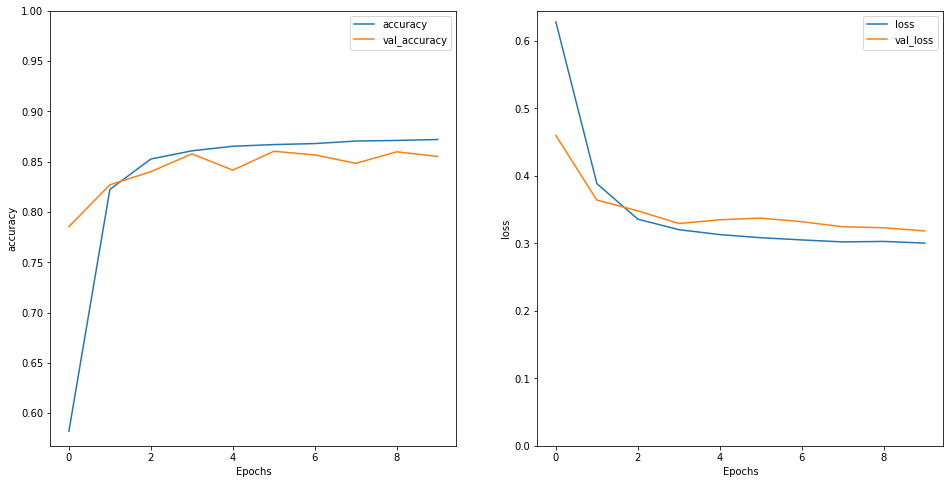

In [17]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)

#Predicting with the Model

###Testing some positive and negative words

Despite searching all over the code and paper from which the dataset comes from, I do not know how big the scale is. Instead I've chosen a few positive and negative words to give a sense of scale.

Testing some positive words to see if the model correlates positive words effectively. Interestingly the word 'better' is seen as a slightly negative word. This is probably because people writing reviews tend to give suggestions as to what could've been done better rather than saying X movie is better than Y.

In [18]:
positive_words = ["good", "better", "best", "amazing", "great", "best amazing"]
for i in range(len(positive_words)):
  predictions = model.predict(np.array([positive_words[i]]))
  print(positive_words[i], predictions[0])

good [0.26153472]
better [-0.2714854]
best [0.52770936]
amazing [0.72587854]
great [0.5553065]
best amazing [1.1812457]


Testing some negative words to see how the model correlates negative words. It's worth noting how much stronger the effect of negative words has on the model, much like how humans tend to think more about the negative side rather than the positive side.

In [19]:
negative_words = ["bad", "worse", "worst", "terrible", "boring"]
for i in range(len(negative_words)):
  predictions = model.predict(np.array([negative_words[i]]))
  print(negative_words[i], predictions[0])

bad [-0.696154]
worse [-1.137489]
worst [-2.0895407]
terrible [-1.1971538]
boring [-1.2372494]


###Predicting the given text

Upload the input files here by running the code and then choosing the desired file to upload.

In [20]:
from google.colab import files
uploaded = files.upload()
uploaded


Saving input.txt to input.txt


{'input.txt': b'"Stop blushing. I\'m not needling, really I\'m not. Do you know, I\r\nhad a dream an hour ago. I lay down for a cat-nap and in this dream\r\nyou and I, Montag, got into a furious debate on books. You towered\r\nwith rage, yelled quotes at me. I calmly parried every thrust. Power, I\r\nsaid, And you, quoting Dr. Johnson, said `Knowledge is more than\r\nequivalent to force!\' And I said, `Well, Dr. Johnson also said, dear boy,\r\nthat "He is no wise man that will quit a certainty for an uncertainty.\'"\r\nStick with the fireman, Montag. All else is dreary chaos!"\r\n"Don\'t listen," whispered Faber. "He\'s trying to confuse. He\'s\r\nslippery. Watch out!"\r\nBeatty chuckled. "And you said, quoting, `Truth will come to light,\r\nmurder will not be hid long!\' And I cried in good humour, \'Oh God, he\r\nspeaks only of his horse!\' And `The Devil can cite Scripture for his\r\npurpose.\' And you yelled, \'This age thinks better of a gilded fool, than\r\nof a threadbare saint 

Parsing the text file to be usable by our model.

In [21]:
file_name = list(uploaded.keys())[0]
print(file_name)
uploaded[file_name]

#input.txt is encoded in binary and its text blocks are split using double returns
text_blocks = uploaded[file_name].decode("utf-8").split("\r\n\r\n")

#print out the first 100 characters to confirm that the text blocks have been properly parsed for use
print(text_blocks[0][:100])
print(text_blocks[1][:100])

input.txt
"Stop blushing. I'm not needling, really I'm not. Do you know, I
had a dream an hour ago. I lay dow
I think you may like to know something of his person and character. He 
had an excellent constituti


Predicting the first block of code. This one is a passage from Farenheit 451 (thank you Mr. Webster) where characters are having a philosophical debate. The model predicts a slightly negative tone, which is what I expected given the setting of this conversation.

In [22]:
sample_text = text_blocks[0]
predictions = model.predict(np.array([sample_text]))
print(predictions[0])
print(sample_text)

[-0.2662613]
"Stop blushing. I'm not needling, really I'm not. Do you know, I
had a dream an hour ago. I lay down for a cat-nap and in this dream
you and I, Montag, got into a furious debate on books. You towered
with rage, yelled quotes at me. I calmly parried every thrust. Power, I
said, And you, quoting Dr. Johnson, said `Knowledge is more than
equivalent to force!' And I said, `Well, Dr. Johnson also said, dear boy,
that "He is no wise man that will quit a certainty for an uncertainty.'"
Stick with the fireman, Montag. All else is dreary chaos!"
"Don't listen," whispered Faber. "He's trying to confuse. He's
slippery. Watch out!"
Beatty chuckled. "And you said, quoting, `Truth will come to light,
murder will not be hid long!' And I cried in good humour, 'Oh God, he
speaks only of his horse!' And `The Devil can cite Scripture for his
purpose.' And you yelled, 'This age thinks better of a gilded fool, than
of a threadbare saint in wisdom's school!' And I whispered gently, 'The
dignity

Predicting the next block of text. This one reads like a recommendation letter, and should score positively. It scored very postively. I expected the model to have issues because of some dated English used in the passage, since the IMDB dataset features exclusively English from the last few decades.

In [23]:
sample_text = text_blocks[1]

predictions = model.predict(np.array([sample_text]))
print(predictions[0])
print(sample_text)

[2.0830526]
I think you may like to know something of his person and character. He 
had an excellent constitution of body, was of middle stature, but well set, 
and very strong; he was ingenious, could draw prettily, was skilled a little 
in music, and had a clear, pleasing voice, so that when he played psalm tunes
 on his violin and sung withal, as he sometimes did in an evening after 
the business of the day was over, it was extremely agreeable to hear. He had 
a mechanical genius too, and, on occasion, was very handy in the use of other 
tradesmen's tools; but his great excellence lay in a sound understanding and 
solid judgment in prudential matters, both in private and publick affairs. 
In the latter, indeed, he was never employed, the numerous family he had to 
educate and the straitness of his circumstances keeping him close to his trade; 
but I remember well his being frequently visited by leading people, who 
consulted him for his opinion in affairs of the town or of the churc